In [1]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_800x800_20x20_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [4]:
in_data = {}

for fname in tqdm(IN_DATA_FNAMES):
    f = open(fname, 'rb') 
    c_in_data = pickle.load(f) 
    f.close()
    for key in c_in_data:
        if(key not in in_data.keys()):
            in_data[key] = np.array(c_in_data[key])
        else:
            in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


for key in in_data:
    print(key, np.shape(in_data[key]))

 46%|████▌     | 23/50 [01:07<01:19,  2.95s/it]


KeyboardInterrupt: 

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [7]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

CMB experiment properties


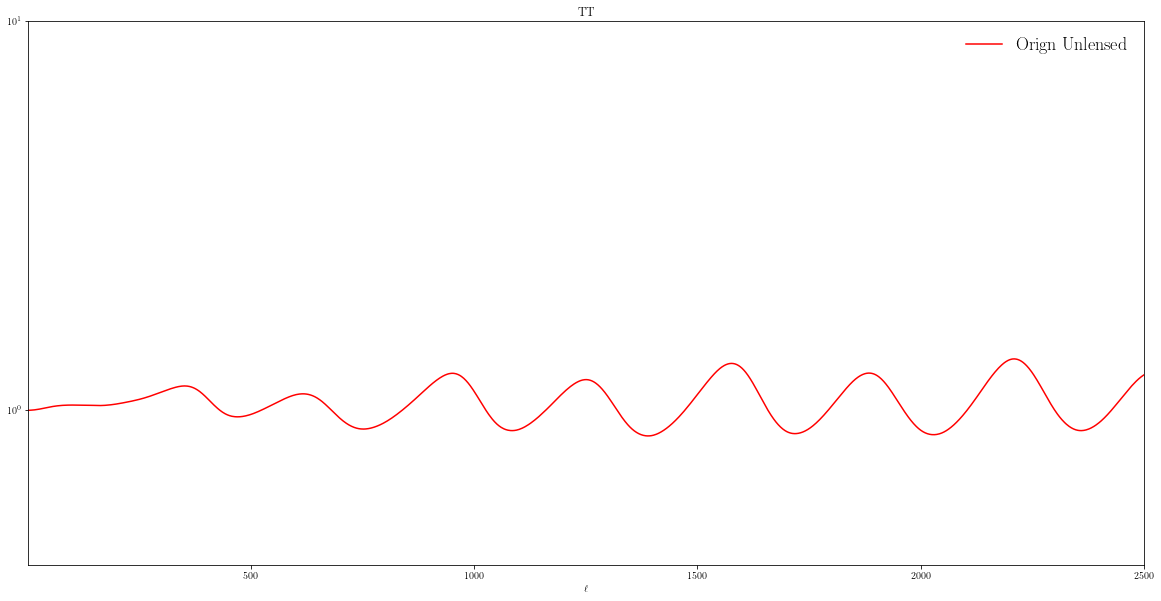

In [10]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
plt.figure(figsize=(20,10))
ls = np.arange(totCL.shape[0])


origTT = list(map(cmb.funlensedTT, ls))


ls2 = np.arange(2,3501)
# plt.plot(ls2, (c_lensed[2:3501,0])/(ls2*(ls2+1)/(2*np.pi)), color='b', label='Lensed clensed')
# plt.scatter(ls,totCL[:,0]/(ls*(ls+1)/(2*np.pi)), color='k', s=5, label='Lensed')

# plt.plot(ls,unlensedCL[:,0]/(ls*(ls+1)/(2*np.pi)), color='C2', label='Unlensed')
# plt.plot(ls,origTT, color='r', label='Orign Unlensed')
plt.plot(ls,origTT/(unlensedCL[:,0]/(ls*(ls+1)/(2*np.pi))), color='r', label='Orign Unlensed')

plt.title('TT')

plt.xlim([2,2500])
plt.ylim([1e-1, 1e1])

plt.legend(frameon=False)
plt.xlabel(r'$\ell$');
plt.yscale('symlog')

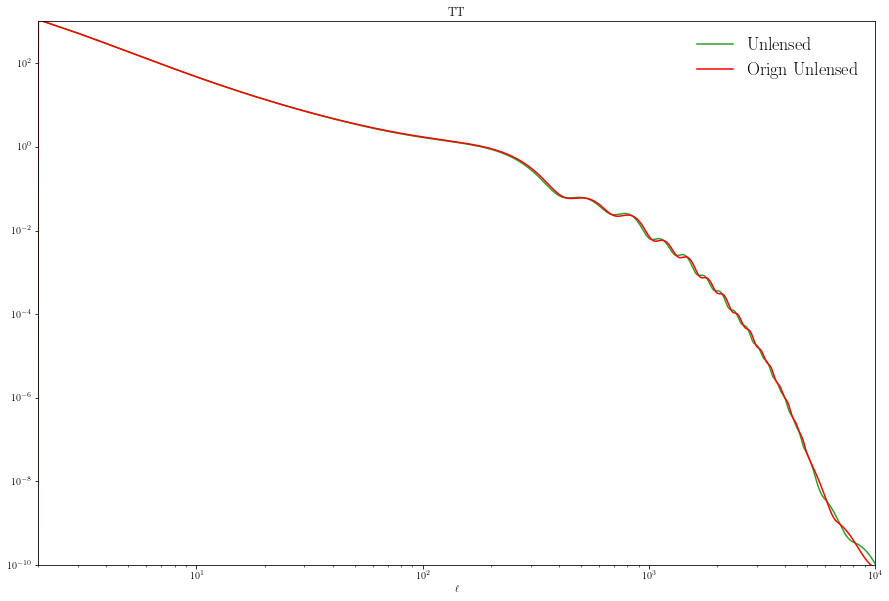

In [9]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
plt.figure(figsize=(15,10))
ls = np.arange(totCL.shape[0])


origTT = list(map(cmb.funlensedTT, ls))


ls2 = np.arange(2,3501)
# plt.plot(ls2, (c_lensed[2:3501,0])/(ls2*(ls2+1)/(2*np.pi)), color='b', label='Lensed clensed')
# plt.plot(ls,totCL[:,0]*ls**4, color='k', label='Lensed')

plt.plot(ls,unlensedCL[:,0]/(ls*(ls+1))*2*np.pi, color='C2', label='Unlensed')
plt.plot(ls,origTT, color='r', label='Orign Unlensed')

plt.title('TT')

plt.xlim([2,10000])
plt.ylim([1e-10, 1e3])
plt.legend(frameon=False)
plt.xlabel(r'$\ell$');
plt.yscale('log')
plt.xscale('log')

In [10]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


(2, 30000)

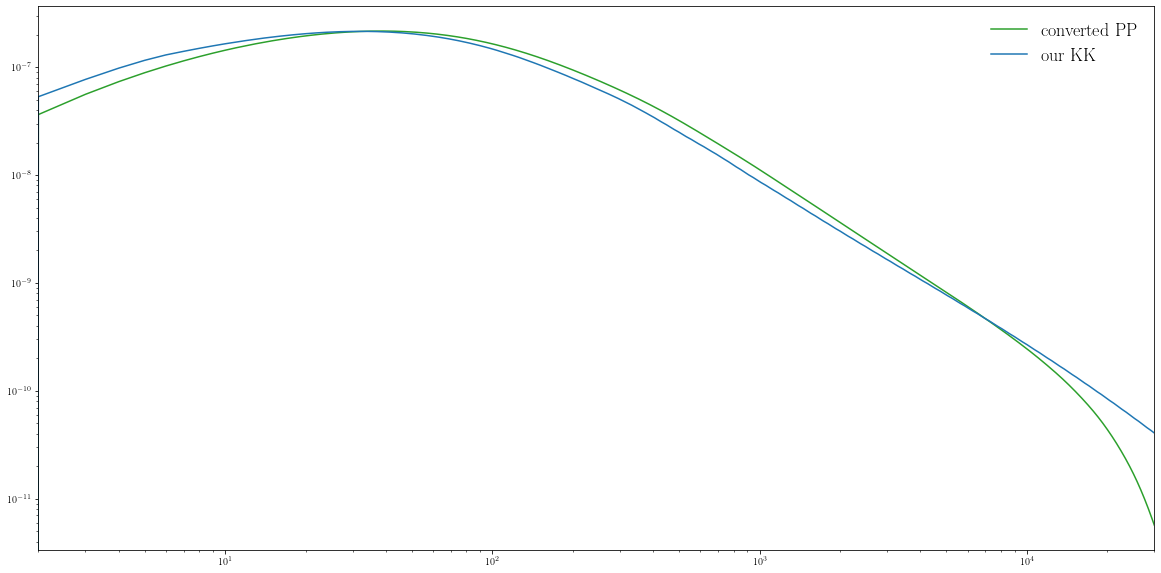

In [11]:
ls = np.arange(cl.shape[0])

plt.figure(figsize=(20,10))
PP = cl[:,0]
rawPP = PP*2*np.pi/((ls*(ls+1))**2)
rawKK = ls**4/4 * rawPP

plt.plot(ls, rawKK, color='C2', label='converted PP')

kk_ours = np.array(list(map(p2d_cmblens.fPinterp, ls)))

# plt.plot(ls, kk_ours*(ls*(ls+1))**2/(2*np.pi)*4/ls**4, label='our KK converted to phi phi')
plt.plot(ls, kk_ours, label='our KK')

plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlim([2,np.max(ls)])

In [12]:
L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [13]:
data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    3: 'lCmbF_o3_1',
    4: 'lCmbF_o4_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}

In [14]:
from tqdm import trange, tqdm



# In[43]:


fgFourier = in_data['fgF_1']
noiseFourier = in_data['noiseF_1']

In [15]:
pair = [-1, -1]
print(pair)


[-1, -1]


In [51]:
L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)

L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(ftot, L)))
ftot = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


In [18]:
# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


In [28]:
L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)


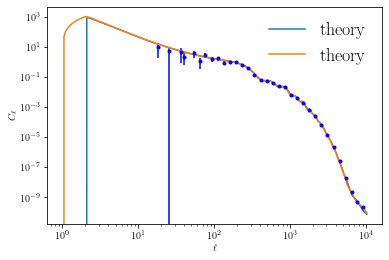

In [31]:
baseMap.powerSpectrum(in_data['cmb0F_1'][0], plot=True, theory=[cmb.funlensedTT, funlensedTT]);

In [46]:
in_data.keys()

dict_keys(['cmb0F_1', 'kCmbF_1', 'lCmbF_1', 'fgF_1', 'noiseF_1', 'totalF_1', 'totalF_0'])

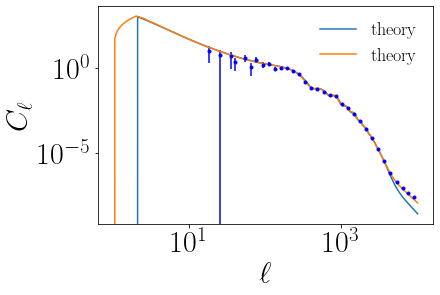

In [52]:
baseMap.powerSpectrum(in_data['lCmbF_1'][0], plot=True, theory=[cmb.flensedTT, flensedTT]);

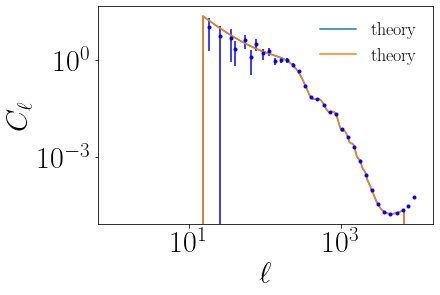

In [53]:
baseMap.powerSpectrum(in_data['totalF_1'][0], plot=True, theory=[cmb.fCtotal, ftot]);

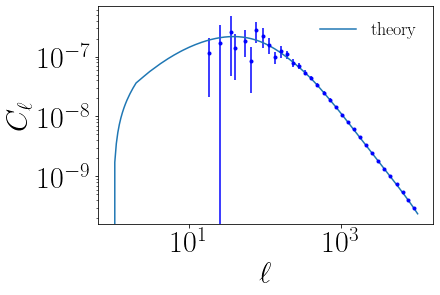

In [49]:
baseMap.powerSpectrum(in_data['kCmbF_1'][0], plot=True, theory=[fKK]);

In [58]:
from multiprocessing import Pool
from tqdm import tqdm
ps_data = {}
ck = 'kkT'

def compute_cls(i):
    kCmbFourier = in_data['kCmbF_1'][i]
    Cls = {}

    cmbo0_F = in_data['cmb0F_1'][i]
    
    cmbo0 = baseMap.inverseFourier(cmbo0_F)
    cmbo1 = baseMap.doLensingTaylor(unlensed=cmbo0, kappaFourier=kCmbFourier, order=1)-cmbo0
    cmbo1_F = baseMap.fourier(cmbo1)

    
    dataFo0 = cmbo0_F + in_data['fgF_1'][i] + in_data['noiseF_1'][i]
    dataFo1 = cmbo1_F + in_data['fgF_1'][i] + in_data['noiseF_1'][i]
    
    
    QE01 = baseMap.computeQuadEstKappaNormLensedWeights(funlensedTT, fTgradT, ftot, 
                                         lMin=lMin, lMax=lMax, 
                                         dataFourier=dataFo0,
                                         dataFourier2=dataFo1)
    QE10 = baseMap.computeQuadEstKappaNormLensedWeights(funlensedTT, fTgradT, ftot, 
                                         lMin=lMin, lMax=lMax, 
                                         dataFourier=dataFo1,
                                         dataFourier2=dataFo0)
    
    Cls['kkT'] = [0, 0, 0]
    Cls['kkT'][0], Cls['kkT'][1], Cls['kkT'][2] = baseMap.crossPowerSpectrum(dataFourier1=QE01 + QE10,
                                                                              dataFourier2=kCmbFourier)
    a, b, c = baseMap.powerSpectrum(kCmbFourier)

    assert((a == Cls['kkT'][0]).all())
    Cls['kkT'][1] -= b
    Cls['kkT'][1] /= b
    Cls['kkT'][2] /= b

    return Cls

N_runs = len(in_data['kCmbF_1'])
# N_runs = 10
with Pool() as pool:
    results = list(tqdm(pool.imap(compute_cls, range(N_runs//10)), total=(N_runs//10)))

for i, result in enumerate(results):
    ck = 'kkT'
    if ck not in ps_data.keys():
        ps_data[ck] = np.array([result[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([result[ck]])))

100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


In [59]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

In [60]:
plt.rcParams.update({'font.size': 30})

50 (50, 3, 50)


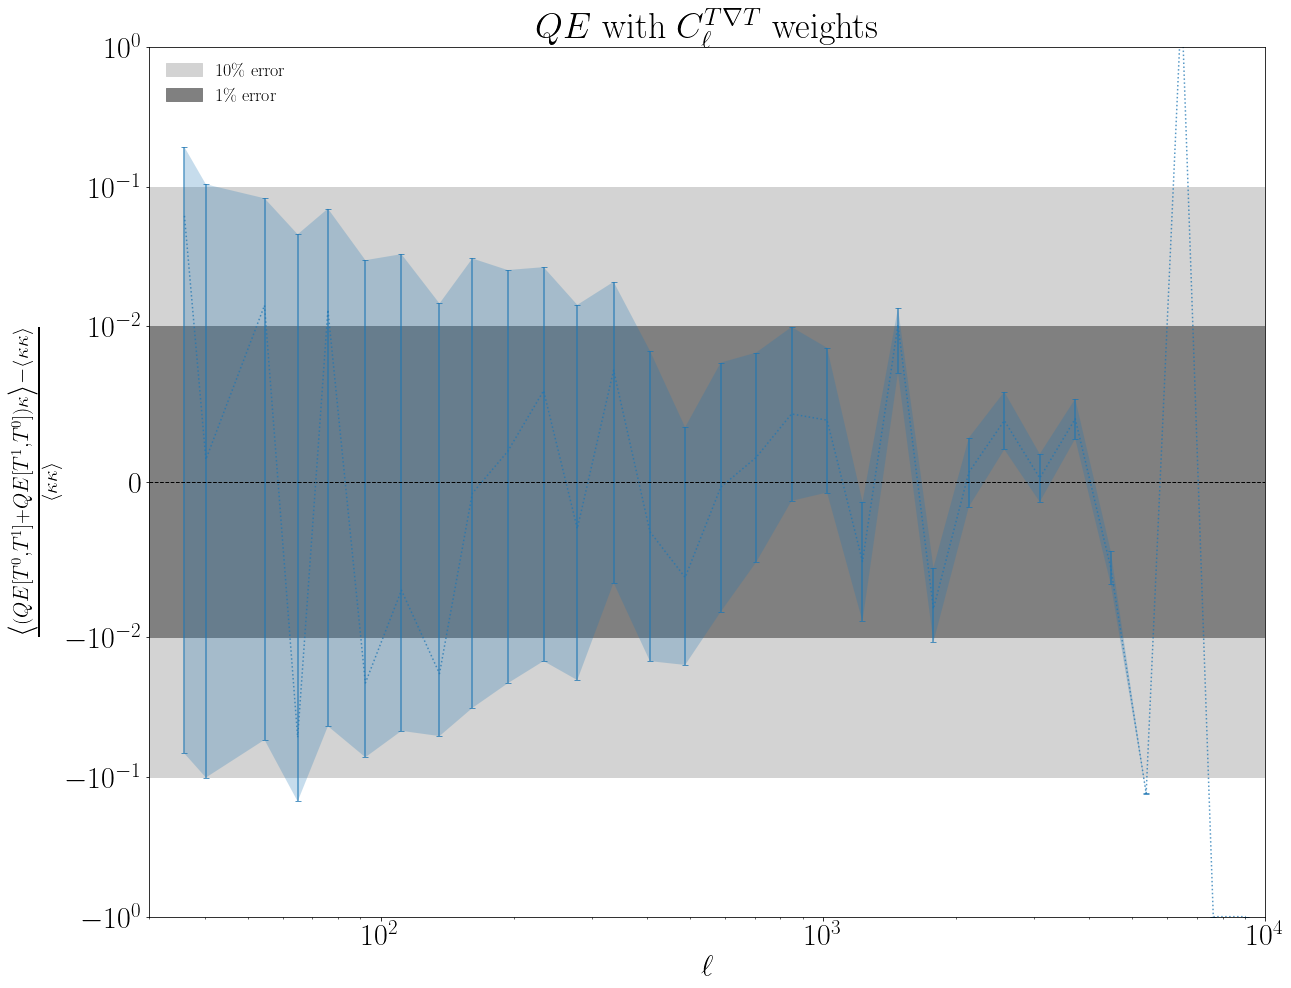

In [61]:
fig,ax = plt.subplots(nrows=1, figsize=(20,16))

lCen, Cl, sCl = combine_Cl(np.array(ps_data[ck]))
ax.fill_between(x=[0,1e4], y1=[-.1, -.1], y2=[.1,.1], color='lightgrey', label='10\% error')
ax.fill_between(x=[0,1e4], y1=[-.01, -.01], y2=[.01,.01], color='grey', label='1\% error')


ax.errorbar(lCen, (Cl), yerr=sCl, alpha=.75, 
            fmt=':', capsize=3, capthick=1)


tmp_data = {
        'x': lCen,
        'y1': [y - e for y, e in zip((Cl), sCl)],
        'y2': [y + e for y, e in zip((Cl), sCl)]}
ax.fill_between(**tmp_data,  alpha=.25)

plt.xscale('log')
plt.xlabel(r'$\ell$')


plt.yscale('symlog', linthresh=.01)

plt.ylabel(r'$\frac{\left<(QE[T^0,T^1]+QE[T^1,T^0]) \kappa\right>-\left<\kappa \kappa\right>}{\left<\kappa \kappa\right>}$')
plt.ylim(-1,1)
plt.xlim(30,1e4)

plt.axhline(0, linewidth=1, linestyle="--", color="black")
plt.title(r'$QE$ with $C_\ell^{T\nabla T}$ weights')
plt.legend(frameon=False)
plt.savefig('figures/check_norm_TgradT_weights.pdf', bbox_inches='tight')